# LSE ST455: Reinforcement Learning

## Seminar 8: Deep Q Networks Methods


You will need to install `tensorflow` to run this notebook locally. Please try `pip install tensorflow`. If `tensorflow` does not support your computer, you may run this notebook remotely on Google colab with this [link](https://colab.research.google.com/drive/1zzfRoBW5pEXcdqSsRLJvTPigZ4rnVOJj#scrollTo=Ved3WSriENha) 

In [1]:
!pip install pygame

     |████████████████████████████████| 8.9 MB 1.5 MB/s eta 0:00:01


# Deep Q-Networks (DQN)

![](graphs/dqn_benchmarks.png)


This exercise aims to replicate the results from the paper [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) published in Nature. This paper develops a DQN that can learn successful policy directly from high-dimensional inputs using end-to-end reinforcement learning.

We will implement the algorithm and test it on the Atari game Breakout. Note that as training for Breakout takes many hours we will not be able to analyze the results in class. Nonetheless, the code can be found in ```dqn_breakout_slow.py``` for reference.

### Basic ideas of DQN

The $Q$ function for Deep Q-Networks is approximated by a neural network architecture

![](graphs/neural_network.png)

#### Experience replay via minibatches

Recall that past state-action-reward tuples are stored in a memory. Random samples are collected to form minibatches on which the parameter updates (e.g. via Stochastic Gradient Descent) are computed. The size of the minibatches trades of a strong variance (too few samples) and computational cost (too many samples)

<img src="graphs/minibatch.png" alt="Drawing" style="width: 750px;"/>
<img src="graphs/experience_replay.png" alt="Drawing" style="width: 750px;"/>

#### Using two cloned networks - Policy and Target Networks

![](graphs/target_network.png)

A source that may cause instability is the correlation between the estimates of the action-value function and the target. 
For example, the DQN loss function at iteration $t$ is defined as

$$\mathcal{L}_t(\theta_t)=\mathbb{E}_{(s,a,r,s'){\sim}U(D)}[(r+{\gamma}\max_{a'}\hat{Q}(s',a';\theta_t)-\hat{Q}(s,a;\theta_t))^2]$$

where $r+{\gamma}\max_{a'}\hat{Q}(s',a';\theta_t)$ is the Q-learning target. 
In DQN, both $Q(s',a';\theta_t)$ that estimates the Q-learning target and 
$Q(s,a;\theta_t)$ that generates actions are parametrised using convolutional neural 
networks where $\theta$ are the network parameters. 
The network that estimates the Q-learning target is usually called *target network* and the one that generates actions is called *policy network*. 

DQN stabilies learning by freezing the target network, i.e., 

$$\mathcal{L}_t(\theta_t)=\mathbb{E}_{(s,a,r,s'){\sim}U(D)}[(r+{\gamma}\max_{a'}\hat{Q}(s',a';\theta_t^{-})-\hat{Q}(s,a;\theta_t))^2].$$

During training, the policy network parameters $\theta_t$ 
are updated per time step, while the target network parameters $\theta_t^{-}$ are only updated every $N$ steps. 




### Breakout - Frame-skipping

![](graphs/atari_breakout.gif)

![](./graphs/breakout_screenshots.png)

These are 30 consecutive frames extracted from the game. If you execute an action in each frame, then there's **no** frame skipping.

In the **Methods** section of the paper, it is said:

>… the agent sees and selects actions on every kth frame instead of every frame, and its last action is repeated on skipped frames. … We use k = 4 for all games except Space Invaders where we noticed that using k = 4 makes the lasers invisible because of the period at which they blink. We used k = 3 to make the lasers visible …

When k = 4, the skipped frames are indicted with an "X" as below:

![](./graphs/breakout_subsampled.png)

In a preprocessing step, image data gets scaled down etc. As the algorithm runs too slowly (10 hours - few days depending on hardware) we leave out the further description and refer to the implementation in ```dqn_breakout_slow.py```.

### Lunar Lander

> The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector.
Reward for moving from the top of the screen to the landing pad and zero speed is about 100..140 points.
If the lander moves away from the landing pad it loses reward. The episode finishes if the lander crashes or
comes to rest, receiving an additional -100 or +100 points. Each leg with ground contact is +10 points.
Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame.
Solved is 200 points.
Landing outside the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land
on its first attempt. Please see the [source code](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py) for details.

<img src="graphs/lunar_lander.png" alt="Drawing" style="width: 500px;"/>

In [2]:
import numpy as np
import gym

import tensorflow.compat.v1 as tf
from tensorflow.keras import Sequential
from tensorflow.keras import models 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import random
from collections import deque

tf.disable_v2_behavior() 

W0308 13:43:22.433171 4472704512 deprecation.py:330] From /usr/local/lib/python3.9/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


Notice that we use [`deque`](https://www.geeksforgeeks.org/deque-in-python/) here to store the data. `deque` is very similar to `list`. It is preferred over a `list` in the cases where we need quicker append and pop operations from both the ends of the container, as deque provides an O(1) time complexity for append and pop operations as compared to list which provides O(n) time complexity.  

Next, we define a few parameters. Again the tradeoff is between performance and running time. The current parameters solve the environment and training runs for about 2 hours.

In [3]:
NUM_EPISODES = 500
DEQUE_MAX_LENGTH = 1000000
LEARNING_RATE = 0.0001
UNITS_PER_LAYER = 128
BATCH_SIZE = 64

The agent implements the DQN learning presented above. It contains two networks (policy and target network). The networks are clones, built with [Keras](https://keras.io). Further experience replay is implemented.

In [4]:
class Agent:
    def __init__(self, env, optimizer, batch_size):
        # general info
        self._state_size = env.observation_space.shape[0] # number of factors in the state; e.g: velocity, position, etc
        self._action_size = env.action_space.n
        self._optimizer = optimizer
        self._batch_size = batch_size
        
        # allow large replay exp space
        self._experience = deque(maxlen=DEQUE_MAX_LENGTH)
        
        self._gamma = 0.99
        # initialize with high exploration, which will decay later
        self._epsilon = 1.0 
        
        # Build Q Network
        self._policy_network = Sequential()
        self._policy_network.add(Dense(UNITS_PER_LAYER, input_dim = self._state_size, activation = "relu"))
        self._policy_network.add(Dense(UNITS_PER_LAYER, activation = "relu"))
        self._policy_network.add(Dense(self._action_size, activation = "linear"))
        
        # Compile Q Network, specify e.g., the loss function, the optimizer
        self._policy_network.compile(loss = "mse", optimizer = self._optimizer)
        
        
        # Build Target Network - Build clone of Q Network
        self._target_network = models.clone_model(self._policy_network)
        
        # Compile Target Network
        self._target_network.compile(loss = "mse", optimizer = self._optimizer)
        
        self.update_target_network()
    
    # add new experience to the replay exp
    def memorize_experience(self, state, action, reward, next_state, done):
        self._experience.append((state, action, reward, next_state, done))
    
    def update_target_network(self):
        return self._target_network.set_weights(self._policy_network.get_weights())
    
    def choose_action(self, state):
        if np.random.rand() < self._epsilon: # exploration
            action = np.random.choice(self._action_size)
        else:
            state = np.reshape(state, [1, state_size])
            qhat = self._policy_network.predict(state) # output Q(s,a) for all a of current state
            action = np.argmax(qhat[0]) # because the output is m * n, so we need to consider the dimension [0]
            
        return action
     
    # update params in Neural Network
    def experience_replay(self):

        # take a mini-batch from replay experience
        cur_batch_size = min(len(self._experience), self._batch_size)
        mini_batch = random.sample(self._experience, cur_batch_size)
        
        # batch data
        sample_states = np.ndarray(shape = (cur_batch_size, self._state_size)) # replace 128 with cur_batch_size
        sample_actions = np.ndarray(shape = (cur_batch_size, 1))
        sample_rewards = np.ndarray(shape = (cur_batch_size, 1))
        sample_next_states = np.ndarray(shape = (cur_batch_size, self._state_size))
        sample_dones = np.ndarray(shape = (cur_batch_size, 1))

 
        for idx, exp in enumerate(mini_batch):
            sample_states[idx], sample_actions[idx], sample_rewards[idx], sample_next_states[idx], sample_dones[idx]  = exp
        
         
        sample_qhat_next = self._target_network.predict(sample_next_states)
        
        # set all Q values terminal states to 0
        sample_qhat_next = sample_qhat_next * (np.ones(shape = sample_dones.shape) - sample_dones)
        # choose max action for each state
        sample_qhat_next = np.max(sample_qhat_next, axis=1)
        
        sample_qhat = self._policy_network.predict(sample_states)
        
        for i in range(cur_batch_size):
            a = sample_actions[i,0]
            sample_qhat[i,int(a)] = sample_rewards[i] + self._gamma * sample_qhat_next[i]
            
        q_target = sample_qhat
            
        self._policy_network.fit(sample_states, q_target, epochs = 1, verbose = 0)
 

The algorithm now runs for the specified number of episodes and updates the parameters in policy (target) network using experience replay 

In [6]:
env = gym.make("LunarLander-v2")
optimizer = Adam(learning_rate = LEARNING_RATE)

agent = Agent(env, optimizer, batch_size = BATCH_SIZE)
state_size = env.observation_space.shape[0]

timestep=0
rewards = []

for episode in range(NUM_EPISODES):
    render_env = episode % 10 == 0
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, info = env.step(action)
        
        if render_env:
            env.render()

        total_reward += reward
        
        agent.memorize_experience(state, action, reward, next_state, done)
        agent.experience_replay()
        
        state = next_state
        timestep += 1
        
    rewards.append(total_reward)
        
    # update target network each episode
    agent.update_target_network()

    # decaying exploration
    agent._epsilon = max(0.1, 0.995 * agent._epsilon) 

    if render_env:
        print(f"Episode {episode}, Reward: {total_reward}")

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2429: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Episode 0, Reward: -339.12829995966763
Episode 10, Reward: -84.30356797545097
Episode 20, Reward: -189.68910442349744
Episode 30, Reward: -132.52574923322783
Episode 40, Reward: -4.103808787565512
Episode 50, Reward: -211.53778094711174
Episode 60, Reward: -65.6879290785064
Episode 70, Reward: -74.73983217754675
Episode 80, Reward: -71.91820819881549
Episode 90, Reward: -11.525383948212337
Episode 100, Reward: -44.478206238944864
Episode 110, Reward: -31.95247900284967
Episode 120, Reward: -89.39369573631328
Episode 130, Reward: 82.01162372450483
Episode 140, Reward: -45.96437110784359
Episode 150, Reward: -75.2914007295113
Episode 160, Reward: -39.48625202835886
Episode 170, Reward: 16.034257896309583
Episode 180, Reward: -132.11176756013543
Episode 190, Reward: 86.83926084147062
Episode 200, Reward: 64.18869858265818
Episode 210, Reward: 38.577219037344975
Episode 220, Reward: 47.88183077113806
Episode 230, Reward: -202.35662831959954
Episode 240, Reward: -115.18386534477119
Episode 

### Plot learning curve

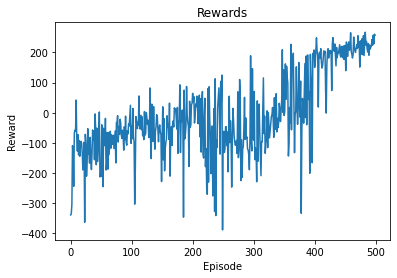

In [7]:
plt.title("Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(rewards)
plt.show()